In [1]:
# importing required modules and reading data. Note that shopping centers are not going to be used in the
# exercise, just there for the idea.
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS

fp1 = 'dataE5/dataE5/TravelTimes_to_5975375_RailwayStation.shp'
fp2 = 'exercise-3-main/shopping_centers.shp'

data1 = gpd.read_file(fp1)
data2 = gpd.read_file(fp2)
print(data1.head())
print(data2.head())

grid = gpd.GeoDataFrame(data1, geometry='geometry')
shop = gpd.GeoDataFrame(data2)

   car_m_d  car_m_t  car_r_d  car_r_t  from_id  pt_m_d  pt_m_t  pt_m_tt  \
0    32297       43    32260       48  5785640   32616     116      147   
1    32508       43    32471       49  5785641   32822     119      145   
2    30133       50    31872       56  5785642   32940     121      146   
3    32690       54    34429       60  5785643   33233     125      150   
4    31872       42    31834       48  5787544   32127     109      126   

   pt_r_d  pt_r_t  pt_r_tt    to_id  walk_d  walk_t  \
0   32616     108      139  5975375   32164     459   
1   32822     111      133  5975375   29547     422   
2   32940     113      133  5975375   29626     423   
3   33233     117      144  5975375   29919     427   
4   32127     101      121  5975375   31674     452   

                                            geometry  
0  POLYGON ((382000.000 6697750.000, 381750.000 6...  
1  POLYGON ((382250.000 6697750.000, 382000.000 6...  
2  POLYGON ((382500.000 6697750.000, 382250.000 6... 

In [2]:
grid = grid.to_crs(3857)
shop = shop.to_crs(3857)
grid.crs == shop.crs

True

In [3]:
# Post number data downloaded from https://hri.fi/data/fi/dataset/paakaupunkiseudun-postinumeroalueet
# Data chosen doesn't take into account the coast/sea areas.

fp2 = 'dataE5/dataE5/PKS_postinumeroalueet_manner_2022/PKS_postinumeroalueet_2022_manner_shp.shp'
data2 = gpd.read_file(fp2)

In [4]:
data2 = gpd.GeoDataFrame(data2, geometry='geometry')

In [5]:
# 'pn' as areas defined by postal number in Uusimaa region.
pn = data2
pn = pn.to_crs(3857)

In [6]:
#data2['area'] = data2['geometry'].area
#data2['area'].max()

In [7]:
pn.crs == grid.crs

True

In [8]:
# centroids for the postal area
pn['centroid']= pn.centroid

In [9]:
#pn['area'] = pn['geometry'].area / 1000000

In [10]:
# I had some difficulties in using the nearest neighbor function so I created centroids from 'grid'-polygons
grid['centroid'] = grid['geometry'].centroid

In [11]:
# I figured I wanted to practise some things with the nearest neighbor method as well and the idea is
# to calculate travel times from different centroids of the postal areas (or closest grid to the centroid) to the city center by PT and car.
# This might not be the optimal way but I wanted to try it. 
# I couldn't get the function to run with geometry columns, I suppose there are some problems
# with the unary union of polygons.

from shapely.geometry import Point, MultiPoint, Polygon
from shapely.ops import nearest_points


def get_nearest_values(row, other_gdf, point_column='centroid', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["centroid"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["centroid"] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

In [105]:
#grid2 = grid.copy()
#grid2['geometry']=grid2['geometry'].centroid

In [12]:
# PT travel times from centroid to city center
pn['pt_r_t'] = pn.apply(get_nearest_values, other_gdf=grid, point_column='centroid', value_column='pt_r_t', axis=1)

In [13]:
# Car travel times
pn['car_r_t'] = pn.apply(get_nearest_values, other_gdf=grid, point_column='centroid', value_column='car_r_t', axis=1)

In [14]:
# road data used in visualisation lesson
roads_fp = "dataE5/dataE5/roads.shp"
roads = gpd.read_file(roads_fp)
roads = roads.to_crs(3857)

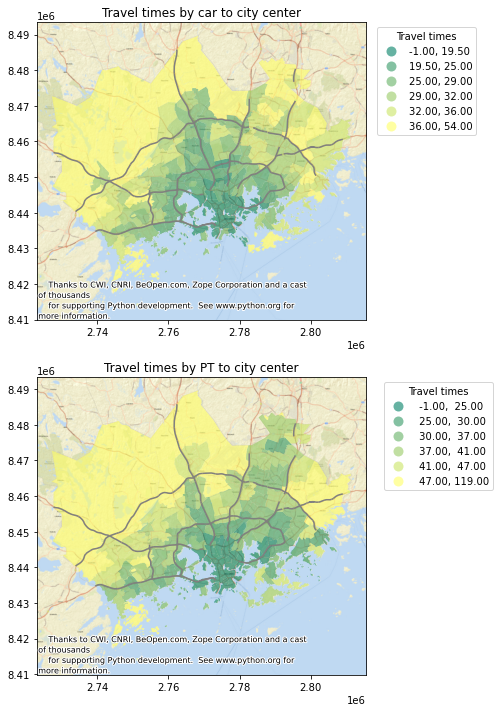

In [15]:
# plotting PT and car travel times with Esri basemap. Note: there are some -1 values in the data.
# They are probably the city center polygons which would have travel times of 0. I didn't remove them from the 
# data since it might make a hole on around the city center.
import contextily as ctx
%matplotlib inline

fig, ax = plt.subplots(nrows = 2, ncols= 1,figsize=(14,10))

#style = "rastertiles/voyager"
#cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style

pn.plot(ax=ax[0], column='car_r_t', 
        scheme='quantiles',
        k=6, 
        cmap='summer',
        legend=True,
       alpha=0.6)

ax[0].get_legend().set_title('Travel times')
ax[0].set_title('Travel times by car to city center')
ax[0].get_legend().set_bbox_to_anchor((1.35,1))
roads.plot(ax=ax[0], color='grey', linewidth = 1.5)

pn.plot(ax=ax[1],
        column='pt_r_t',
        scheme='quantiles', 
        k=6, 
        cmap='summer', 
        legend=True,
       alpha= 0.6)

ax[1].get_legend().set_title('Travel times')
ax[1].set_title('Travel times by PT to city center')
ax[1].get_legend().set_bbox_to_anchor((1.4,1))
roads.plot(ax=ax[1], color='grey', linewidth = 1.5)

ctx.add_basemap(ax[0], zoom= 12, attribution = credits, source=ctx.providers.Esri.WorldStreetMap)
ctx.add_basemap(ax[1], zoom= 12, attribution = credits, source=ctx.providers.Esri.WorldStreetMap)
plt.tight_layout()

outfp = "Exercise-5-master/Exercise-5-master/docs/Travel_times.png"
plt.savefig(outfp, dpi=400)

In [175]:
outfp = "Exercise_5_1.png"
plt.savefig(outfp, dpi=400)

<Figure size 432x288 with 0 Axes>